# Avocado prediction: Total Volume

## with LASSO and Gradient boosting

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('price-and-sales-data.csv')

In [3]:
df.head()

,Date,AveragePrice,TotalVolume,4046,4225,4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,2015-01-04,NaN,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,2015-01-04,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,2015-01-04,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston


In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].dt.week

In [5]:
df.rename(columns={'Date': 'Week','4046': 'Type1','4225': 'Type2','4770': 'Type3'}, inplace=True)

In [6]:
df.head()

,Week,AveragePrice,TotalVolume,Type1,Type2,Type3,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,1,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,1,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,1,NaN,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,1,1.01,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,1,1.02,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston


In [7]:
df.loc[df.AveragePrice.isnull(), 'AveragePrice'] = df.groupby('region').AveragePrice.transform('mean')
df.loc[df.TotalVolume.isnull(), 'TotalVolume']   = df.groupby('region').TotalVolume.transform('mean')
df.loc[df.Type1.isnull(), 'Type1']               = df.groupby('region').Type1.transform('mean')
df.loc[df.Type2.isnull(), 'Type2']               = df.groupby('region').Type2.transform('mean')
df.loc[df.Type3.isnull(), 'Type3']               = df.groupby('region').Type3.transform('mean')
df.loc[df.TotalBags.isnull(), 'TotalBags']       = df.groupby('region').TotalBags.transform('mean')
df.loc[df.SmallBags.isnull(), 'SmallBags']       = df.groupby('region').SmallBags.transform('mean')
df.loc[df.LargeBags.isnull(), 'LargeBags']       = df.groupby('region').LargeBags.transform('mean')
df.loc[df.XLargeBags.isnull(), 'XLargeBags']     = df.groupby('region').XLargeBags.transform('mean')

In [8]:
df.head()

,Week,AveragePrice,TotalVolume,Type1,Type2,Type3,TotalBags,SmallBags,LargeBags,XLargeBags,type,year,region
0,1,1.220000,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,1,1.000000,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
2,1,1.500987,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,BaltimoreWashington
3,1,1.010000,80034.32,44562.12,24964.23,2752.35,7755.62,6064.30,1691.32,0.0,conventional,2015,Boise
4,1,1.020000,491738.00,7193.87,396752.18,128.82,87663.13,87406.84,256.29,0.0,conventional,2015,Boston


In [10]:
# drop features that are not known: average price etc. 
df.drop(df.columns[[1,3,4,5,6,7,8,9]],axis=1,inplace=True)
df.head()

,Week,TotalVolume,type,year,region
0,1,40873.28,conventional,2015,Albany
1,1,435021.49,conventional,2015,Atlanta
2,1,788025.06,conventional,2015,BaltimoreWashington
3,1,80034.32,conventional,2015,Boise
4,1,491738.00,conventional,2015,Boston


In [14]:
df_tot_train = df[df['year']!=2019]
df_tot_test  = df[df['year']==2019]

In [21]:
#df_tot_train.shape
df_tot_train.head()

,Week,TotalVolume,type,year,region
0,1,40873.28,conventional,2015,Albany
1,1,435021.49,conventional,2015,Atlanta
2,1,788025.06,conventional,2015,BaltimoreWashington
3,1,80034.32,conventional,2015,Boise
4,1,491738.00,conventional,2015,Boston


In [22]:
#df_tot_test.shape
df_tot_test.head()

,Week,TotalVolume,type,year,region
22137,2,44749707.48,conventional,2019,TotalUS
22138,2,129222.29,conventional,2019,Albany
22139,2,828971.15,conventional,2019,Atlanta
22140,2,925391.38,conventional,2019,BaltimoreWashington
22141,2,108261.98,conventional,2019,Boise


In [23]:
# label encoding (not one hot encoding)
le = preprocessing.LabelEncoder()
df_tot_train['type'] = le.fit_transform(df_tot_train['type'])
df_tot_test['type'] = le.fit_transform(df_tot_test['type'])

In [24]:
# one hot encoding
df_tot_train = pd.get_dummies(df_tot_train, columns = ['region'], drop_first=False)
df_tot_test = pd.get_dummies(df_tot_test, columns = ['region'], drop_first=False)

In [25]:
df_tot_train.head()

,Week,TotalVolume,type,year,region_Albany,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,1,40873.28,0,2015,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,435021.49,0,2015,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,788025.06,0,2015,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,80034.32,0,2015,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,491738.00,0,2015,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_tot_test.head()

,Week,TotalVolume,type,year,region_Albany,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
22137,2,44749707.48,0,2019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22138,2,129222.29,0,2019,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22139,2,828971.15,0,2019,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22140,2,925391.38,0,2019,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22141,2,108261.98,0,2019,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Predicting the Total Volume with LASSO

In [30]:
X_train = df_tot_train.iloc[:,[0] + [x for x in range(2,len(df_tot_train.columns))]] 
y_train = df_tot_train.iloc[:,1]

X_test = df_tot_test.iloc[:,[0] + [x for x in range(2,len(df_tot_test.columns))]] 
y_test = df_tot_test.iloc[:,1]

In [32]:
X_train.head()

,Week,type,year,region_Albany,region_Atlanta,region_BaltimoreWashington,region_Boise,region_Boston,region_BuffaloRochester,region_California,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,1,0,2015,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,2015,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,2015,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,2015,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,2015,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y_train.head()

0     40873.28
1    435021.49
2    788025.06
3     80034.32
4    491738.00
Name: TotalVolume, dtype: float64

In [36]:
scaler  = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)

model = Lasso(random_state=42, max_iter=1000)

alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

In [37]:
random_grid = GridSearchCV(model, tuned_parameters, cv=n_folds, refit=False)
random_grid.fit(X_train_s, y_train)
scores = random_grid.cv_results_['mean_test_score']
scores_std = random_grid.cv_results_['std_test_score']

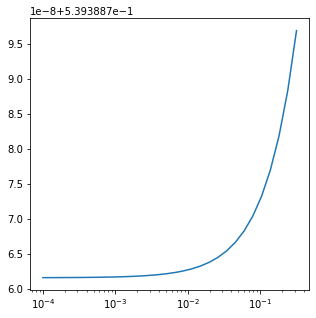

In [38]:
plt.figure(figsize=(5,5))
plt.semilogx(alphas, scores)

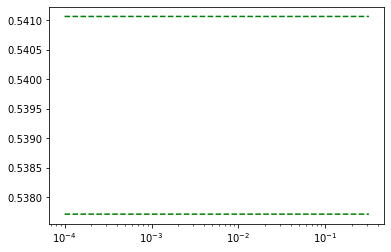

In [39]:
# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)
plt.semilogx(alphas, scores + std_error, 'g--')
plt.semilogx(alphas, scores - std_error, 'g--')

(0.0001, 0.31622776601683794)

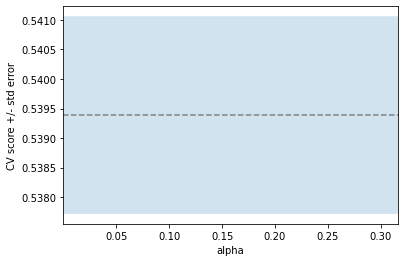

In [40]:
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2) # alpha controls the fill color
plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [41]:
model.fit(X_train_s,y_train)

Lasso(random_state=42)

In [42]:
X_test_s = scaler.fit_transform(X_test)
pred = model.predict(X_test_s)

<AxesSubplot:xlabel='TotalVolume', ylabel='Density'>

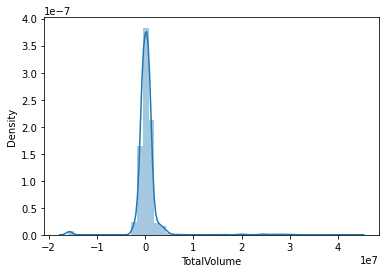

In [43]:
sns.distplot(y_test - pred,bins=50)

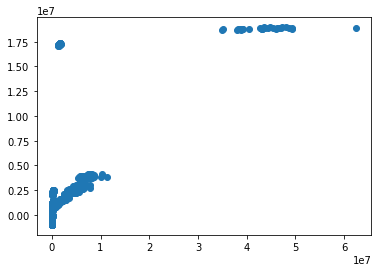

In [44]:
plt.scatter(y_test,pred)

In [45]:
r2_score(y_test,pred)

0.5229133189697756

## Predicting the Total Volume with Gradient boosting

In [46]:
n_estimators = [int(x) for x in np.linspace(start=40,stop=100,num=15)] # The number of trees in the forest
max_features = ['sqrt','log2'] # 'auto','sqrt','log2' The number of features to consider when looking for the best split
max_depth    = [int(x) for x in np.linspace(start=5,stop=15,num=5)]
min_smp_splt = sorted(np.random.randint(200,1200,10))
min_smp_leaf = sorted(np.random.randint(40,70,10))

random_grid  = {'n_estimators':n_estimators,
                'max_features':max_features,
                'max_depth':max_depth,
                'min_samples_split':min_smp_splt,
                'min_samples_leaf':min_smp_leaf
}

print(random_grid)

{'n_estimators': [40, 44, 48, 52, 57, 61, 65, 70, 74, 78, 82, 87, 91, 95, 100], 'max_features': ['sqrt', 'log2'], 'max_depth': [5, 7, 10, 12, 15], 'min_samples_split': [249, 349, 353, 357, 395, 517, 546, 726, 1108, 1158], 'min_samples_leaf': [42, 42, 44, 47, 52, 57, 60, 62, 62, 67]}


In [47]:
model = GradientBoostingRegressor(learning_rate=0.05,subsample=0.85)
model_random = RandomizedSearchCV(estimator=model,
                                  param_distributions=random_grid,
                                  scoring='neg_mean_squared_error',
                                  n_iter=25,
                                  n_jobs=-1,
                                  cv=5,
                                  verbose=2,
                                  random_state=1
)

In [48]:
model_random.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(learning_rate=0.05,
                                                       subsample=0.85),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 10, 12, 15],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [42, 42, 44, 47, 52,
                                                             57, 60, 62, 62,
                                                             67],
                                        'min_samples_split': [249, 349, 353,
                                                              357, 395, 517,
                                                              546, 726, 1108,
                                                              1158],
                                        'n_estimators': [40, 44, 48, 52, 57, 61,
                                  

In [49]:
pred = model_random.predict(X_test)

(-10000000.0, 10000000.0)

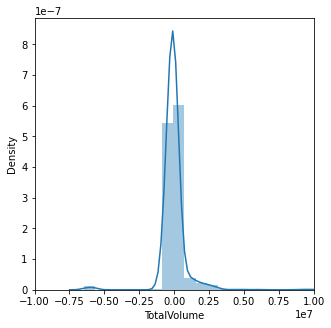

In [53]:
plt.figure(figsize=(5,5))
sns.distplot(y_test - pred)
plt.xlim(-1e7, 1e7)

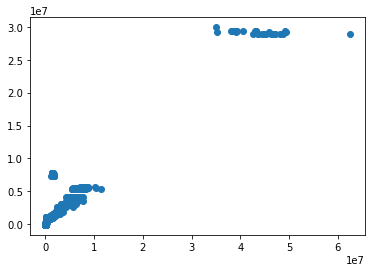

In [51]:
plt.scatter(y_test,pred)

In [52]:
r2_score(y_test,pred)

0.8506168200731647